# **Импорт библиотек**

In [2]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, UpSampling1D, MaxPooling2D, Flatten, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import matplotlib.pyplot as plt
from PIL import Image

# **Загрузка данных**

In [ ]:
from google.colab import files

In [ ]:
from google.colab import drive


# Загрузка файлов с Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Распаковка архива с фото**

In [ ]:
!unzip '/content/drive/MyDrive/hack_ton/train_dataset.zip' -d '/content/drive/MyDrive/hack_ton/train_images'

Archive:  /content/drive/MyDrive/hack_ton/train_dataset.zip
replace /content/drive/MyDrive/hack_ton/train_images/train_dataset/1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## **Проверка данных**

In [ ]:
csv_path = '/content/drive/MyDrive/hack_ton/train.csv'
train_images_path = '/content/drive/MyDrive/hack_ton/train_images/train_dataset'

to_train_path = '/content/drive/MyDrive/hack_ton/sorted_img_data/train/to_train'
validate_path = '/content/drive/MyDrive/hack_ton/sorted_img_data/valid/dt/validate'

for_gen_train = '/content/drive/MyDrive/hack_ton/sorted_img_data/train'
for_gen_val = '/content/drive/MyDrive/hack_ton/sorted_img_data/valid'

In [ ]:
import os


# Вывод количества файлов содержащихся в директории
train_dir_len = len(os.listdir(validate_path + f'/True'))
print("Length:\t", train_dir_len)

Length:	 2317


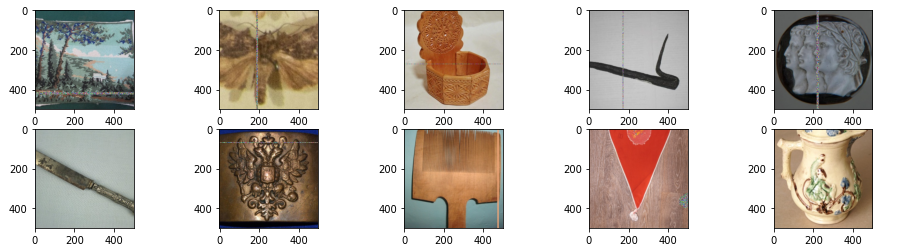

In [5]:
# Вывод некоторых изображений
pictures = os.listdir('/content/drive/MyDrive/hack_ton/sorted_img_data/train/to_train/False')[0:10]

out_pic_box = plt.figure(figsize=(16, 4))
plt.axis('off')

for num, picture in enumerate(pictures):
    pic = Image.open('/content/drive/MyDrive/hack_ton/sorted_img_data/train/to_train/False' + f'/{picture}')
    pic = pic.resize((500, 500))

    out_pic_box.add_subplot(2, 5, num + 1)
  
    plt.imshow(pic)

plt.show()

# **Работа с CSV**

In [6]:
train_data = pd.read_csv(csv_path)

In [7]:
train_data.head(10)

,name,is_corrupted
0,1.png,1
1,2.png,0
2,3.png,0
3,4.png,0
4,5.png,1
5,6.png,0
6,7.png,0
7,8.png,1
8,9.png,1
9,10.png,1


# **Перемещение файлов в нужные дериктории**

In [ ]:
import shutil


# Перемещаем фото изходя из метки is_corrupted
st = 0
for root, dirs, files in os.walk(train_images_path):  
    for filename in files:
        if st % 4 != 0:
            if train_data.is_corrupted[st]:
                shutil.move(train_images_path + f'/{train_data.name[st]}', to_train_path + f'/True')
                st += 1
            else:
                shutil.move(train_images_path + f'/{train_data.name[st]}', to_train_path + f'/False')
                st += 1
        else:
            if train_data.is_corrupted[st]:
                shutil.move(train_images_path + f'/{train_data.name[st]}', validate_path + f'/True')
                st += 1
            else:
                shutil.move(train_images_path + f'/{train_data.name[st]}', validate_path + f'/False')
                st += 1

# **Создание генераторов**

In [9]:
# Создание генератора
train_image_generator = ImageDataGenerator(rescale=1./255)
train_data_gen = train_image_generator.flow_from_directory(batch_size=32,
                                                          directory='/content/drive/MyDrive/hack_ton/sorted_img_data/train/to_train',
                                                          shuffle=True,
                                                          target_size=(300, 300),
                                                          class_mode='binary')

val_image_generator = ImageDataGenerator(rescale=1./255)
val_data_gen = val_image_generator.flow_from_directory(batch_size=32,
                                                          directory='/content/drive/MyDrive/hack_ton/sorted_img_data/valid/dt/validate',
                                                          shuffle=True,
                                                          target_size=(300, 300),
                                                          class_mode='binary')

Found 14035 images belonging to 2 classes.
Found 4680 images belonging to 2 classes.


In [10]:
print(train_data_gen.class_indices)
print(val_data_gen.class_indices)

{'False': 0, 'True': 1}
{'False': 0, 'True': 1}


# **Создание и обучение модели**

In [11]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 128)      0

In [13]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit_generator(train_data_gen,
                              steps_per_epoch=32,
                              epochs=16,
                              validation_data=val_data_gen,
                              validation_steps=32)

model.save('/content/drive/MyDrive/hack_ton/model.h5')

# **Потери и точность**

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Точность на обучении')
plt.plot(epochs_range, val_acc, label='Точность на валидации')
plt.legend(loc='lower right')
plt.title('Точность на обучающих и валидационных данных')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Потери на обучении')
plt.plot(epochs_range, val_loss, label='Потери на валидации')
plt.legend(loc='upper right')
plt.title('Потери на обучающих и валидационных данных')
plt.savefig('./foo.png')
plt.show()

# **Решение задачи**

In [ ]:
from google.colab import files
files.upload()

Saving test_dataset.zip to test_dataset.zip


In [ ]:
!unzip '/content/test_dataset.zip' -d '/content/test_imgs'

Archive:  /content/test_dataset.zip
   creating: /content/test_imgs/test_dataset/
 extracting: /content/test_imgs/test_dataset/100.png  
 extracting: /content/test_imgs/test_dataset/10010.png  
 extracting: /content/test_imgs/test_dataset/10068.png  
 extracting: /content/test_imgs/test_dataset/10104.png  
 extracting: /content/test_imgs/test_dataset/10114.png  
 extracting: /content/test_imgs/test_dataset/10131.png  
 extracting: /content/test_imgs/test_dataset/10132.png  
 extracting: /content/test_imgs/test_dataset/10136.png  
 extracting: /content/test_imgs/test_dataset/10139.png  
 extracting: /content/test_imgs/test_dataset/1014.png  
 extracting: /content/test_imgs/test_dataset/10225.png  
 extracting: /content/test_imgs/test_dataset/10252.png  
 extracting: /content/test_imgs/test_dataset/10258.png  
 extracting: /content/test_imgs/test_dataset/10266.png  
 extracting: /content/test_imgs/test_dataset/10275.png  
 extracting: /content/test_imgs/test_dataset/10306.png  
 extracti

In [4]:
from PIL import Image
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import pandas as pd


model = load_model('/content/drive/MyDrive/hack_ton/model.h5')

In [ ]:
from PIL import Image
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd


test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        "/content/test_imgs/",
        target_size=(300, 300),
        batch_size=20,
        class_mode='binary',
        shuffle=False)

pred = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)

cl = np.round(pred)
cl = cl.astype(int)
print(cl)

In [ ]:
for i in cl:
    print(i)

In [36]:
filenames = test_generator.filenames
cor_fnames = [i.replace('test_dataset/', '') for i in filenames]
results = pd.DataFrame({"name":cor_fnames, "is_corrupted":cl[:,0]})

In [90]:
cl[:,0].shape

(1004,)

In [51]:
results.to_csv('result.csv', index=False)


In [61]:
from natsort import natsorted

reader = csv.reader(open("result.csv"), delimiter=",")
sortedlist = natsorted(reader)

In [96]:
sortedlist

[['24.png', '0'],
 ['34.png', '0'],
 ['43.png', '0'],
 ['70.png', '0'],
 ['82.png', '0'],
 ['83.png', '1'],
 ['100.png', '1'],
 ['106.png', '0'],
 ['116.png', '1'],
 ['133.png', '1'],
 ['156.png', '0'],
 ['248.png', '0'],
 ['261.png', '1'],
 ['263.png', '0'],
 ['283.png', '0'],
 ['290.png', '0'],
 ['296.png', '0'],
 ['298.png', '1'],
 ['355.png', '0'],
 ['356.png', '1'],
 ['380.png', '1'],
 ['384.png', '1'],
 ['393.png', '0'],
 ['398.png', '1'],
 ['399.png', '0'],
 ['408.png', '0'],
 ['436.png', '0'],
 ['448.png', '1'],
 ['480.png', '0'],
 ['486.png', '0'],
 ['557.png', '1'],
 ['568.png', '0'],
 ['601.png', '0'],
 ['619.png', '0'],
 ['639.png', '1'],
 ['653.png', '1'],
 ['668.png', '0'],
 ['700.png', '0'],
 ['744.png', '0'],
 ['745.png', '1'],
 ['828.png', '0'],
 ['837.png', '0'],
 ['844.png', '0'],
 ['907.png', '1'],
 ['928.png', '1'],
 ['965.png', '0'],
 ['1014.png', '1'],
 ['1056.png', '0'],
 ['1070.png', '0'],
 ['1084.png', '0'],
 ['1085.png', '0'],
 ['1106.png', '0'],
 ['1166.png'

In [86]:
name = np.array([i[0] for i in sortedlist])
ans = np.array([i[1] for i in sortedlist])

In [92]:
ans.shape

(1005,)

In [99]:
import csv


# field names
fields = ['name', 'is_corrupted']
with open('results_dt.csv', 'w') as f:
	write = csv.writer(f)
	
	write.writerow(fields)
	write.writerows(sortedlist)


In [88]:
sorted.head(5)

name            [24.png, 34.png, 43.png, 70.png, 82.png, 83.pn...
is_corrupted    [0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, ...
dtype: object